/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_13238/3549541116.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="1993-04-01")
[*********************100%***********************]  1 of 1 completed


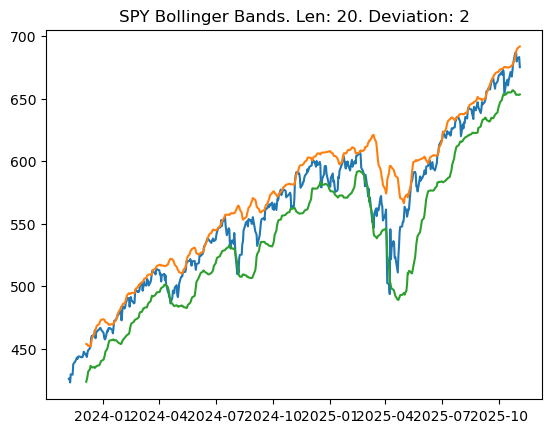

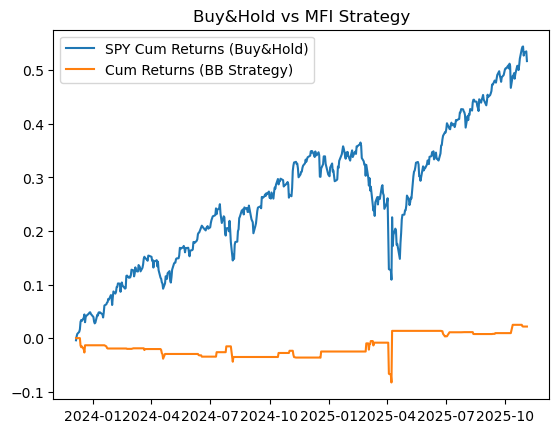

In [ ]:
## Strategy based on the Standard Deviation of Close Prices over a Lookback Window

import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

TICKER = "SPY"
BB_LENGTH = 20
STD_DEV = 2 # Default for Bollinger Bands
LOOKBACK = 500

def get_data(ticker=TICKER):
    df = yf.download(ticker, start="1993-04-01")
    df.columns = df.columns.get_level_values(0)

    return df.iloc[-LOOKBACK:,:]

def add_bollinger_bands(df, std_dev = STD_DEV, length = BB_LENGTH):
        # Step 1: Build the BB Columns
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
    df["BB_STD"] = df["Close"].rolling(window=length).std()
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
    # In Coding Practice, you are not supposed to create a New Column for every value you want to see
    # but in this video, it is pretty valuable. It is tho slower, larger and this is not optimal
        
        # Step 2: Plot the BB
    plt.figure()
    plt.plot(df["Close"]) # Blue
    plt.plot(df["Upper Band"]) # Orange
    plt.plot(df["Lower Band"]) # Green
    plt.title(f"{TICKER} Bollinger Bands. Len: {BB_LENGTH}. Deviation: {STD_DEV}")

    return df.dropna()
    # Drop na, since it takes us 20 days to get the first rollings average values 

def add_strategy(df):
    df["Strategy"] = np.where(df["Close"] > df["Upper Band"], -1, 
                    np.where(df["Close"] < df["Lower Band"], 1, 0))
    # Short Signal: -1 (Close > Upper Band) --> Multilple Leverage: -3
    # Long Signal: 1 (Close < Lower Band) --> Multilple Leverage: 3
    # Hold Signal: 0 (Close not > Upper Band, nor < Lower Band)

    # Shift the signal to prevent lookahead bias - we can only understand Data after it happens:
    df["Strategy"] = df["Strategy"].shift(1)
    
    return df 

def test_strategy(df):
    df["asset_cum_returns"] = (1 + df["Close"].pct_change()).cumprod() - 1
    # For each day: 
        # Daily percentage return: pct_change = (price_today - price_yesterday) / price_yesterday = 0.2 ... -0.1
        # Convert Daily Returns into Growth Factors: (1 + ...) = 1.02 ... -0.99
        # Multiply all Daily Growth Factors: cumprod() = 1.02 * 0.99 = 1.0098
        # Convert Growth Factors back to Percentage : -1 = 0.0098 = +0.98%
    df["strategy_cum_returns"] = (1 + df["Close"].pct_change() * df["Strategy"]).cumprod() - 1

    plt.figure()
    plt.plot(df["asset_cum_returns"])
    plt.plot(df["strategy_cum_returns"])
    plt.legend([f"{TICKER} Cum Returns (Buy&Hold)", "Cum Returns (BB Strategy)"])
    plt.title("Buy&Hold vs MFI Strategy")

    return df


def main():
    df = get_data()
    df = add_bollinger_bands(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()

In [23]:
df

Price,Close,High,Low,Open,Volume,BB_SMA,BB_STD,Upper Band,Lower Band,Strategy,asset_cum_returns,strategy_cum_returns
Date,,,,,,,,,,,,
2023-12-05,445.096741,446.061790,443.410314,443.790503,69793500,438.609856,7.554522,453.718901,423.500811,NaN,NaN,NaN
2023-12-06,443.303131,447.280330,442.864456,447.251087,69124700,439.478900,6.997337,453.473575,425.484225,0.0,-0.004030,0.000000
2023-12-07,446.685699,447.338803,444.794572,445.398947,66995400,440.501474,6.431400,453.364274,427.638674,0.0,0.003570,0.000000
2023-12-08,448.606049,449.142180,445.691356,445.935058,83194400,441.786270,5.176413,452.139096,431.433444,0.0,0.007884,0.000000
2023-12-11,450.350952,450.526440,447.894450,448.108909,65002200,442.828343,4.645461,452.119266,433.537420,0.0,0.011805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,687.390015,689.700012,682.869995,688.719971,85657100,670.550494,8.701689,687.953872,653.147116,-1.0,0.544361,0.021623
2025-10-30,679.830017,685.940002,679.830017,683.900024,76335800,671.080997,8.936557,688.954111,653.207882,0.0,0.527376,0.021623
2025-10-31,682.059998,685.080017,679.239990,685.039978,87164100,671.723495,9.251347,690.226189,653.220802,0.0,0.532386,0.021623
